In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn import metrics, ensemble
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import BayesianRidge

In [ ]:
training_data = pd.read_csv('/content/drive/MyDrive/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')
features = pd.read_csv('/content/drive/MyDrive/features.csv')
stores = pd.read_csv('/content/drive/MyDrive/stores.csv')

In [ ]:
training_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
training_data.shape

(421570, 5)

In [ ]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
np.random.seed(42)

#Data Cleaning / Preprocessing

In [ ]:
def gen_season(month):
    if month >= 3 and month <= 5:
        return "Spring"
    elif month >= 6 and month <= 8:
        return "Summer"
    elif month >= 9 and month <= 11:
        return "Autumn"
    else:
        return "Winter"


In [ ]:
features_extended = features.merge(stores, on = "Store", how = "left")
features_extended_subset = features_extended.drop("IsHoliday", axis = 1)
whole_training = training_data.merge(features_extended_subset, on = ['Store', 'Date'], how = "left")
whole_training['Date'] = pd.to_datetime(whole_training['Date'], format='%Y-%m-%d')
month_train = whole_training['Date'].dt.month
whole_training['Season'] = month_train.apply(gen_season)

In [ ]:
def set_holiday_week(df, holiday_week_dates):
    df['Date'] = pd.to_datetime(df['Date'])

    for holiday_date in holiday_week_dates:
        # Find the index of the holiday date
        holiday_index = df['Date'].sub(pd.to_datetime(holiday_date)).abs().idxmin()

        # Find the indices of the two closest dates before the holiday
        closest_dates = df['Date'].iloc[holiday_index-2: holiday_index].index

        # Set 'IsHoliday' to True for the closest dates using .loc[]
        df.loc[closest_dates, 'IsHoliday'] = True

    return df

holiday_week_dates = ['2010-01-01', '2010-07-04', '2010-11-25', '2010-12-25', '2011-01-01', '2011-07-04', '2011-11-24',
                      '2011-12-25', '2012-01-01', '2012-07-04', '2012-11-22', '2012-12-25', '2010-02-14', '2011-02-14',
                      '2012-02-14', '2010-09-01', '2011-09-01', '2012-09-01', '2010-05-09', '2011-05-08', '2012-05-13',
                      '2010-10-31', '2011-10-31', '2012-10-31', '2010-12-22', '2011-12-28', '2012-12-16']

whole_training = set_holiday_week(whole_training, holiday_week_dates)

In [ ]:
whole_training.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Season
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,Winter
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,Winter
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,Winter
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,Winter
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,Spring


#EDA

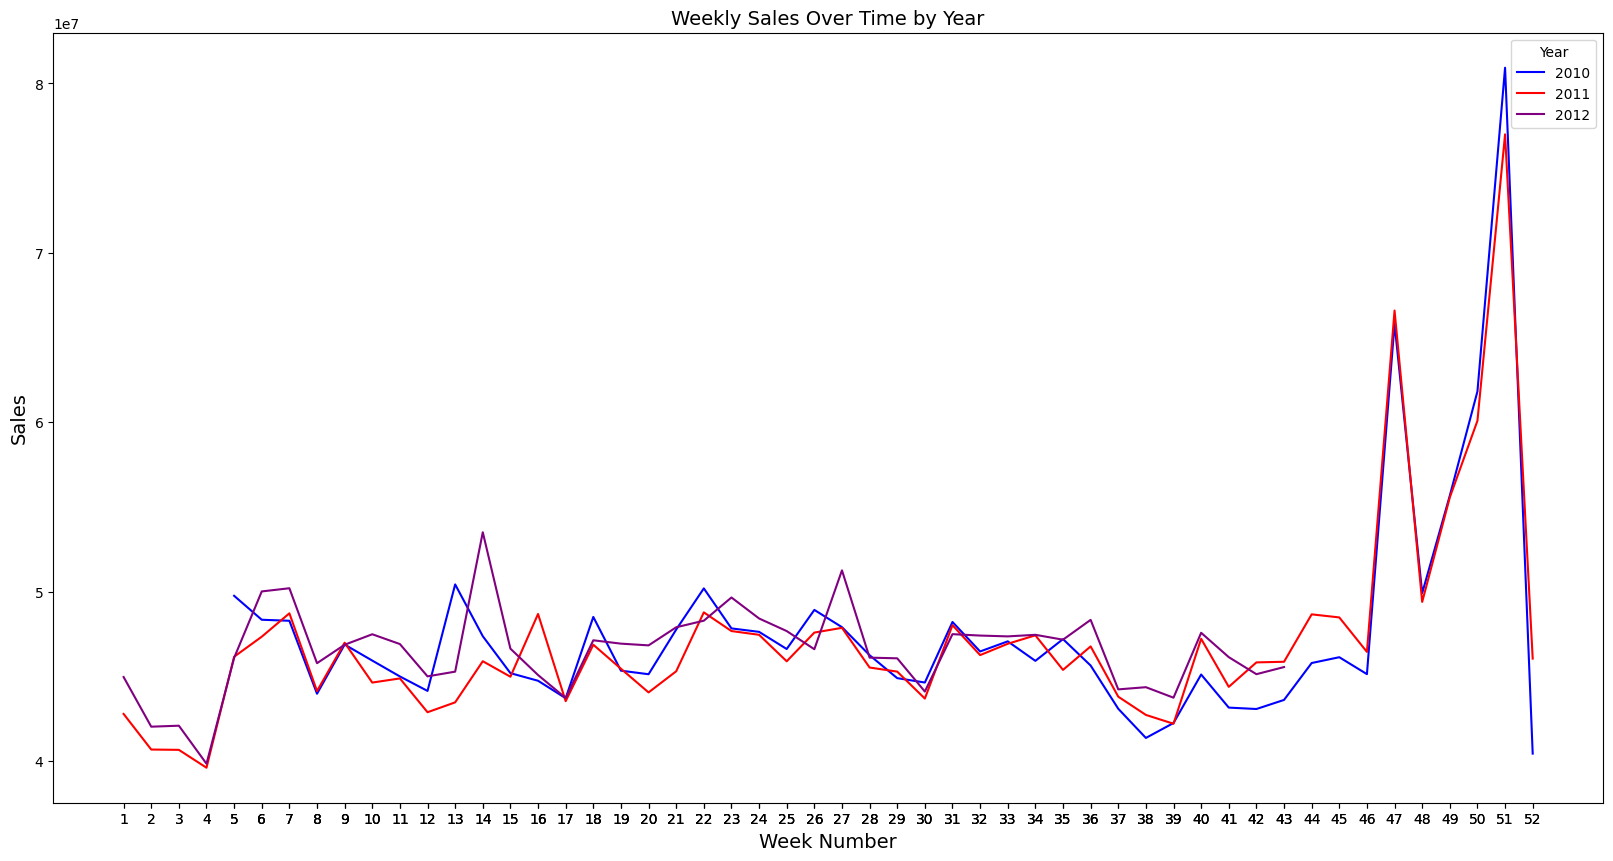

In [ ]:
whole_training['Date'] = pd.to_datetime(whole_training['Date'])
whole_training['Week'] = pd.to_numeric(whole_training['Date'].dt.strftime('%W'))
whole_training['Year'] = whole_training['Date'].dt.year

grouped_data = whole_training.groupby(['Year', 'Week'])['Weekly_Sales'].sum().reset_index()

grouped_data = grouped_data.sort_values(by=['Year', 'Week'])

fig, ax = plt.subplots(figsize=(20, 10))

color_map = {2010: 'blue', 2011: 'red', 2012: 'purple'}

for year, group in grouped_data.groupby('Year'):
    ax.plot(group['Week'], group['Weekly_Sales'], label=str(year), color=color_map[year])

ax.set_xticks(grouped_data['Week'])
ax.set_xlabel('Week Number',  fontsize=14)
ax.set_ylabel('Sales',  fontsize=14)
ax.set_title('Weekly Sales Over Time by Year',  fontsize=14)
ax.legend(title='Year')

plt.show()

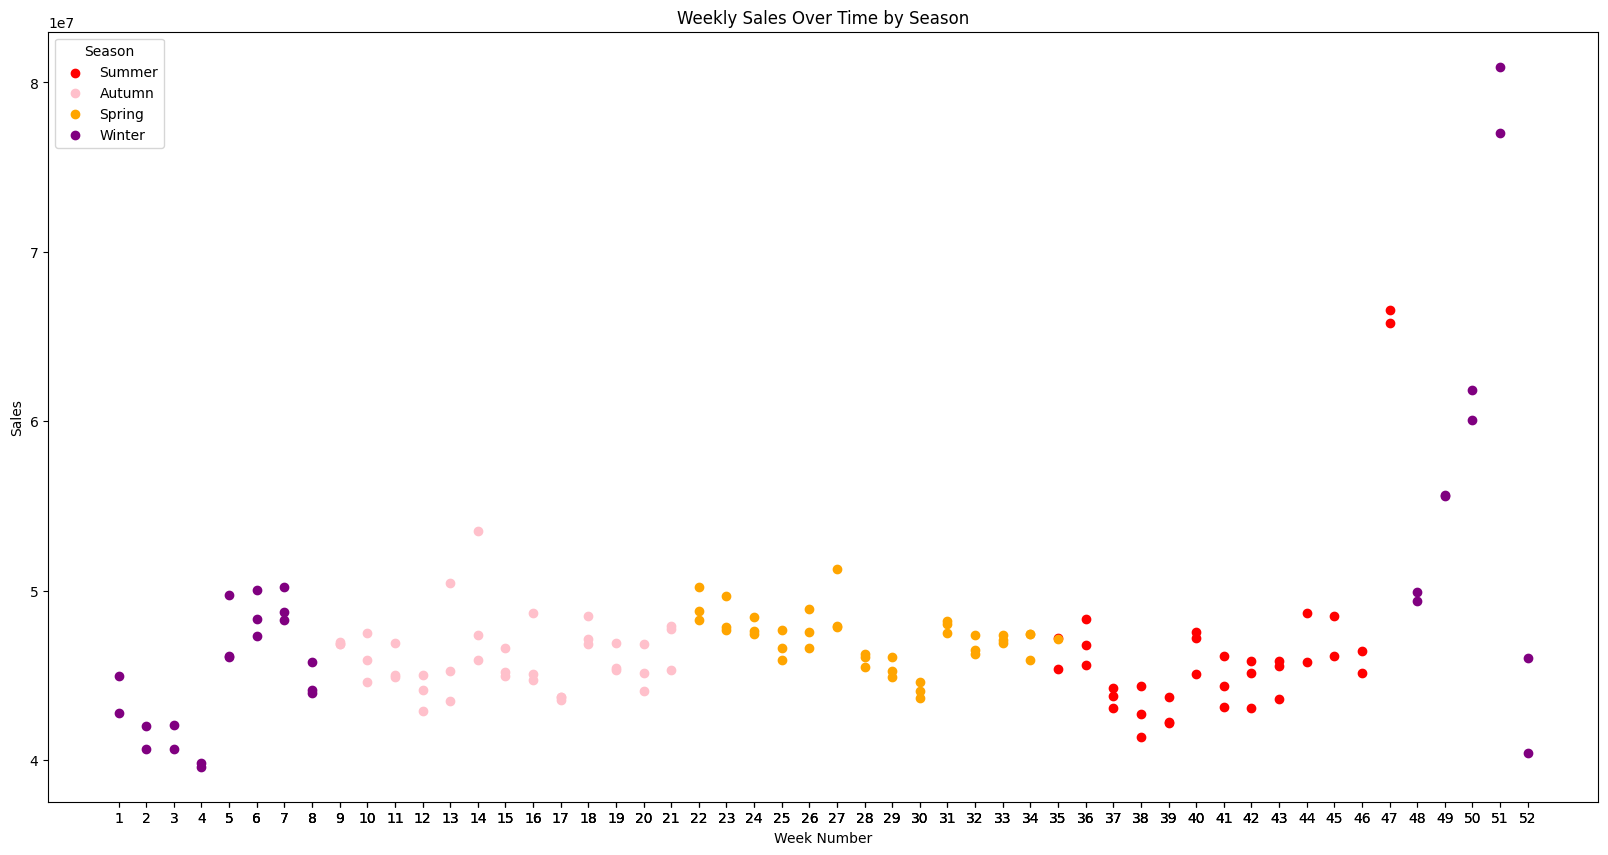

In [ ]:
whole_training['Date'] = pd.to_datetime(whole_training['Date'])
whole_training['Week'] = pd.to_numeric(whole_training['Date'].dt.strftime('%W'))
whole_training['Year'] = whole_training['Date'].dt.year

whole_training['Month'] = whole_training['Date'].dt.month

grouped_data = whole_training.groupby(['Year', 'Week', 'Season'])['Weekly_Sales'].sum().reset_index()

grouped_data = grouped_data.sort_values(by=['Year', 'Week', 'Season'])

fig, ax = plt.subplots(figsize=(20, 10))

color_map = {'Spring': 'pink', 'Summer': 'orange', 'Autumn': 'red', 'Winter': 'purple'}

added_to_legend = set()

for season, group in grouped_data.groupby('Season'):
    ax.scatter(group['Week'], group['Weekly_Sales'], label=season, color=color_map[season])
    added_to_legend.add(season)

ax.set_xlabel('Week Number')
ax.set_ylabel('Sales')
ax.set_title('Weekly Sales Over Time by Season')
ax.legend(title='Season', labels=added_to_legend)

ax.set_xticks(grouped_data['Week'])

plt.show()

In [ ]:
whole_training.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Season', 'Week',
       'Year', 'Month'],
      dtype='object')

<ipython-input-15-229ac94fee26>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = selected_df.corr()


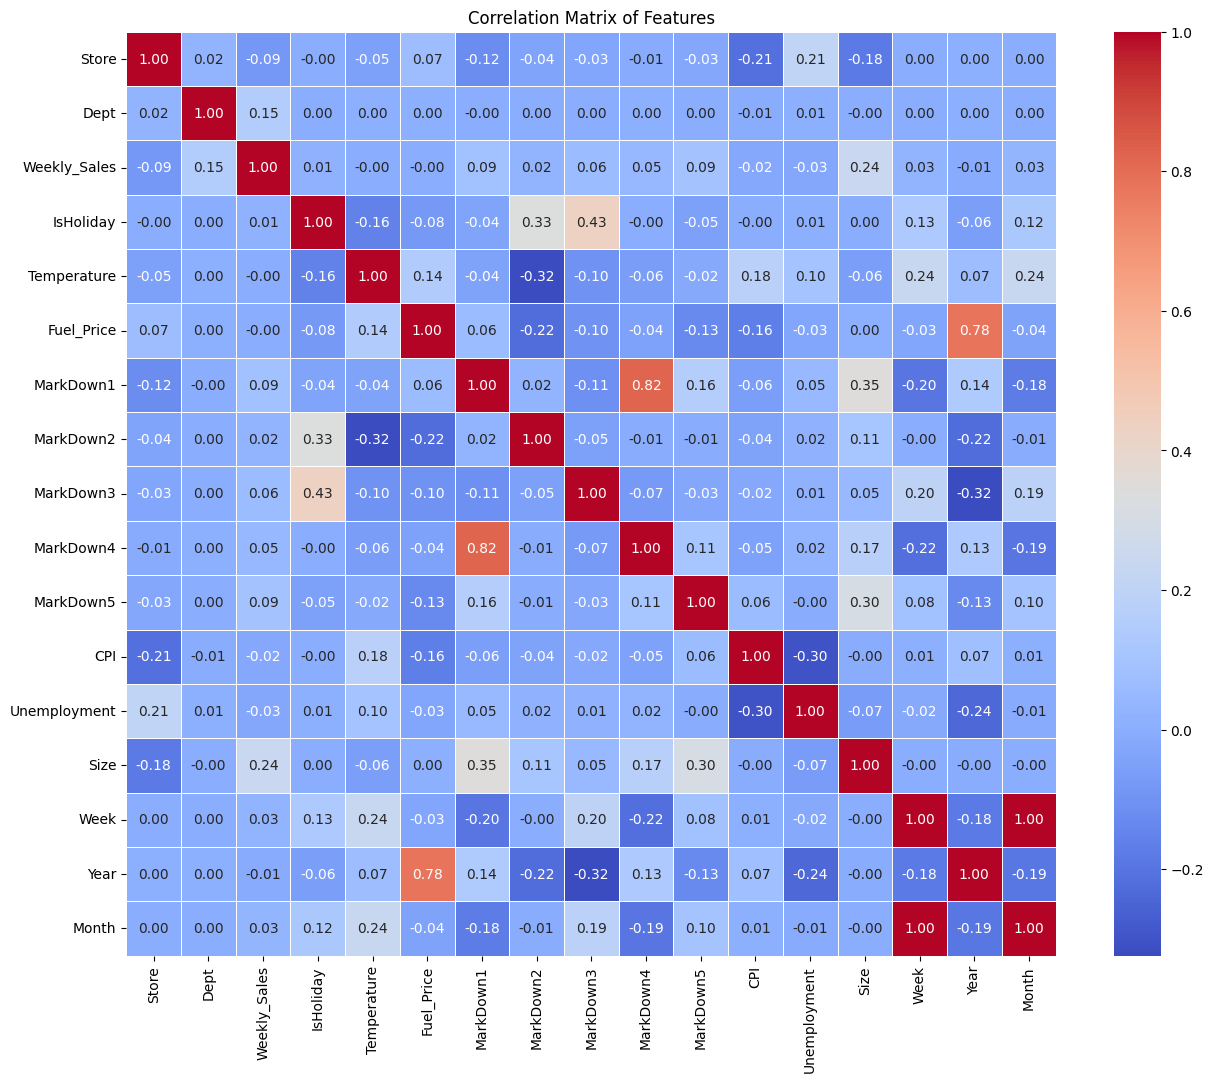

In [ ]:
selected_features = ['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Temperature',
                      'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
                      'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Season', 'Week',
                      'Year', 'Month']

selected_df = whole_training[selected_features]

correlation_matrix = selected_df.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.show()


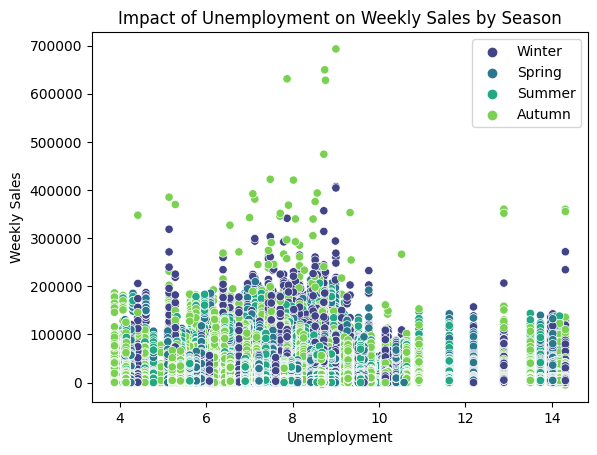

In [ ]:
sns.scatterplot(x='Unemployment', y='Weekly_Sales', hue='Season', data= whole_training, palette='viridis')

plt.xlabel('Unemployment')
plt.ylabel('Weekly Sales')
plt.title('Impact of Unemployment on Weekly Sales by Season')

plt.legend()

plt.show()

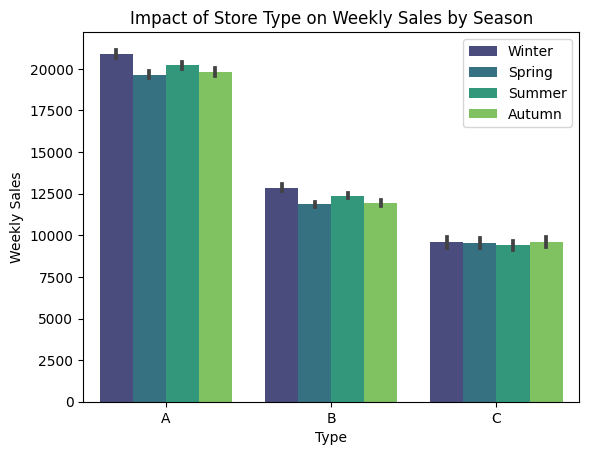

In [ ]:
sns.barplot(x='Type', y='Weekly_Sales', hue='Season', data= whole_training, palette='viridis')

plt.xlabel('Type')
plt.ylabel('Weekly Sales')
plt.title('Impact of Store Type on Weekly Sales by Season')

plt.legend()

plt.show()

In [ ]:
print(whole_training['Season'].unique())

print(whole_training.groupby(['Season', 'IsHoliday']).size())

['Winter' 'Spring' 'Summer' 'Autumn']
Season  IsHoliday
Autumn  False         85484
        True          14830
Spring  False        115091
        True              6
Summer  False        117274
        True             12
Winter  False         74023
        True          14850
dtype: int64


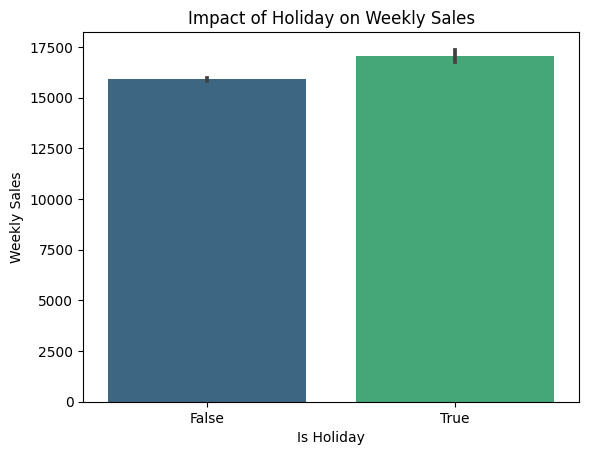

In [ ]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=whole_training, palette='viridis')

plt.xlabel('Is Holiday')
plt.ylabel('Weekly Sales')
plt.title('Impact of Holiday on Weekly Sales')

plt.show()

# Model

In [ ]:
whole_training_summer = whole_training[whole_training['Season'] == "Summer"]
whole_training_winter = whole_training[whole_training['Season'] == "Winter"]
whole_training_autumn = whole_training[whole_training['Season'] == "Autumn"]
whole_training_spring = whole_training[whole_training['Season'] == "Spring"]

In [ ]:
def preprocess(data):
    if data['Type'].dtype != 'int64':
        type_mapping = {"A" : 3, "B": 2, "C":1}
        data['Type'] = data['Type'].map(type_mapping)
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
    month_train = data['Date'].dt.month
    data['Season'] = month_train.apply(gen_season)
    if len(data['Season'].unique()) > 1:
#         season_mapping = {"Winter": 1, "Spring":2, "Summer": 3, "Autumn" : 4}
#         data['Season'] = data['Season'].map(season_mapping)
        dummies = pd.get_dummies(data['Season'])
        data = pd.concat([data,dummies], axis=1)
    data['Year'] = data['Date'].dt.year
    if len(data['Season'].unique()) > 1:
        holder = data[['Store', 'Dept','IsHoliday', 'Size', 'Year', 'CPI','Type', 'Temperature', 'Fuel_Price', 'Summer', 'Winter', 'Autumn', 'Spring']]
    else:
        holder = data[['Store', 'Dept','IsHoliday', 'Size', 'Year', 'CPI','Type', 'Temperature', 'Fuel_Price']]
    scaler = StandardScaler().fit(holder)
    X_scaler = holder.copy()
    X_scaler[holder.columns.to_list()] = scaler.transform(holder)
    return X_scaler


In [ ]:
def wmae(true, predicted, data):
    def get_weights(holiday):
        if holiday == True:
            return 5
        else:
            return 1
    data_copy = data.copy()
    data_copy['w'] = data_copy['IsHoliday'].apply(get_weights)

    sum_weights = np.sum(data_copy['w'])
    weights = np.array(data_copy['w'])
    diff = np.abs(true - predicted)
    wmae = np.sum(np.multiply(weights, diff)) / sum_weights
    return wmae


In [ ]:
# All Data Preprocessing
X = preprocess(whole_training)
y = whole_training['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.3)

In [ ]:
# Autumn Data Preprocessing
X_autumn = preprocess(whole_training_autumn)
y_autumn = whole_training_autumn['Weekly_Sales']
X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn = train_test_split(X_autumn, y_autumn, random_state = 42, test_size=0.3)


<ipython-input-37-36fcd36ba08a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Type'] = data['Type'].map(type_mapping)
<ipython-input-37-36fcd36ba08a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
<ipython-input-37-36fcd36ba08a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [ ]:
# Spring Data Preprocessing
X_spring = preprocess(whole_training_spring)
y_spring = whole_training_spring['Weekly_Sales']
X_train_spring, X_test_spring, y_train_spring, y_test_spring = train_test_split(X_spring, y_spring, random_state = 42, test_size=0.3)

<ipython-input-37-36fcd36ba08a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Type'] = data['Type'].map(type_mapping)
<ipython-input-37-36fcd36ba08a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
<ipython-input-37-36fcd36ba08a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [ ]:
# Summer Data Preprocessing
X_summer = preprocess(whole_training_summer)
y_summer = whole_training_summer['Weekly_Sales']
X_train_summer, X_test_summer, y_train_summer, y_test_summer = train_test_split(X_summer, y_summer, random_state = 42, test_size=0.3)

<ipython-input-37-36fcd36ba08a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Type'] = data['Type'].map(type_mapping)
<ipython-input-37-36fcd36ba08a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
<ipython-input-37-36fcd36ba08a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [ ]:
# Winter Data Preprocessing
X_winter = preprocess(whole_training_winter)
y_winter = whole_training_winter['Weekly_Sales']
X_train_winter, X_test_winter, y_train_winter, y_test_winter = train_test_split(X_winter, y_winter, random_state = 42, test_size=0.3)

<ipython-input-37-36fcd36ba08a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Type'] = data['Type'].map(type_mapping)
<ipython-input-37-36fcd36ba08a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
<ipython-input-37-36fcd36ba08a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [ ]:
## Linear Regression

In [ ]:
# All data
regr = LinearRegression()
regr.fit(X_train, y_train)
lin_reg_pred = regr.predict(X_test)

lin_all = wmae(y_test,lin_reg_pred, X_test)

In [ ]:
# Spring only data
regr = LinearRegression()
regr.fit(X_train_spring, y_train_spring)
lin_reg_pred = regr.predict(X_test_spring)

lin_spring = wmae(y_test_spring,lin_reg_pred, X_test_spring)

In [ ]:
# Autumn only data
regr = LinearRegression()
regr.fit(X_train_autumn, y_train_autumn)
lin_reg_pred = regr.predict(X_test_autumn)

lin_autumn = wmae(y_test_autumn,lin_reg_pred, X_test_autumn)

In [ ]:
# Summer only data
regr = LinearRegression()
regr.fit(X_train_summer, y_train_summer)
lin_reg_pred = regr.predict(X_test_summer)

lin_summer = wmae(y_test_summer,lin_reg_pred, X_test_summer)

In [ ]:
# Winter only data
regr = LinearRegression()
regr.fit(X_train_winter, y_train_winter)
lin_reg_pred = regr.predict(X_test_winter)

lin_winter = wmae(y_test_winter,lin_reg_pred, X_test_winter)

In [ ]:
lin_values = [lin_all , lin_spring, lin_autumn, lin_summer, lin_winter]

In [ ]:
lin_values

[14565.126257337573,
 14107.698570666258,
 14464.357147176397,
 14474.485524933149,
 15267.110080633563]

In [ ]:
## Random Forest Regressor

In [ ]:
# All data
RF = RandomForestRegressor(n_estimators=100, max_depth = 20)
RF.fit(X_train, y_train)
predict_rf = RF.predict(X_test)

rf_all = wmae(y_test,predict_rf, X_test)

In [ ]:
# Spring only data
RF = RandomForestRegressor(n_estimators=100, max_depth = 20)
RF.fit(X_train_spring, y_train_spring)
predict_rf = RF.predict(X_test_spring)

rf_spring = wmae(y_test_spring,predict_rf, X_test_spring)

In [ ]:
# Autumn only data
RF = RandomForestRegressor(n_estimators=100, max_depth = 20)
RF.fit(X_train_autumn, y_train_autumn)
predict_rf = RF.predict(X_test_autumn)

rf_autumn = wmae(y_test_autumn,predict_rf, X_test_autumn)

In [ ]:
# Summer only data
RF = RandomForestRegressor(n_estimators=100, max_depth = 20)
RF.fit(X_train_summer, y_train_summer)
predict_rf = RF.predict(X_test_summer)

rf_summer = wmae(y_test_summer,predict_rf, X_test_summer)

In [ ]:
# Winter only data
RF = RandomForestRegressor(n_estimators=100, max_depth = 20)
RF.fit(X_train_winter, y_train_winter)
predict_rf = RF.predict(X_test_winter)

rf_winter = wmae(y_test_winter,predict_rf, X_test_winter)

In [ ]:
rf_values = [rf_all , rf_spring, rf_autumn, rf_summer, rf_winter]

In [ ]:
rf_values

[1899.871611089567,
 1511.0934943120146,
 1639.799570425515,
 1570.3202142729513,
 2694.1226891432475]

In [ ]:
## Gradient Boosting Regression

In [ ]:
# All data
gbr = XGBRegressor(n_estimators=1000, max_depth=12, learning_rate = 0.1)
gbr.fit(X_train, y_train)
predict_gbr = gbr.predict(X_test)

gbr_all = wmae(y_test,predict_gbr, X_test)

In [ ]:
# Spring only data
gbr = XGBRegressor(n_estimators=1000, max_depth=12, learning_rate = 0.1)
gbr.fit(X_train_spring, y_train_spring)
predict_gbr = gbr.predict(X_test_spring)

gbr_spring = wmae(y_test_spring,predict_gbr, X_test_spring)

In [ ]:
# Autumn only data
gbr = XGBRegressor(n_estimators=1000, max_depth=12, learning_rate = 0.1)
gbr.fit(X_train_autumn, y_train_autumn)
predict_gbr = gbr.predict(X_test_autumn)

gbr_autumn = wmae(y_test_autumn,predict_gbr, X_test_autumn)

In [ ]:
# Summer only data
gbr = XGBRegressor(n_estimators=1000, max_depth=12, learning_rate = 0.1)
gbr.fit(X_train_summer, y_train_summer)
predict_gbr = gbr.predict(X_test_summer)

gbr_summer = wmae(y_test_summer,predict_gbr, X_test_summer)

In [ ]:
# Winter only data
gbr = XGBRegressor(n_estimators=1000, max_depth=12, learning_rate = 0.1)
gbr.fit(X_train_winter, y_train_winter)
predict_gbr = gbr.predict(X_test_winter)

gbr_winter = wmae(y_test_winter,predict_gbr, X_test_winter)

In [ ]:
gbr_values = [gbr_all, gbr_spring, gbr_autumn, gbr_summer, gbr_winter]

In [ ]:
gbr_values

[1588.8094094517112,
 1382.5701183449016,
 1496.015346077443,
 1456.0736410885102,
 2209.989089375517]

In [ ]:
## Bayesian Ridge Regression

In [ ]:
# All data
bayesian_ridge_model = BayesianRidge(alpha_1=0.1, lambda_2=0.1)
bayesian_ridge_model.fit(X_train, y_train)
predict_br = bayesian_ridge_model.predict(X_test)

br_all = wmae(y_test,predict_br, X_test)

In [ ]:
# Spring only data
bayesian_ridge_model = BayesianRidge(alpha_1=0.1, lambda_2=0.1)
bayesian_ridge_model.fit(X_train_spring, y_train_spring)
predict_br = bayesian_ridge_model.predict(X_test_spring)

br_spring = wmae(y_test_spring,predict_br, X_test_spring)

In [ ]:
# Autumn only data
bayesian_ridge_model = BayesianRidge(alpha_1=0.1, lambda_2=0.1)
bayesian_ridge_model.fit(X_train_autumn, y_train_autumn)
predict_br = bayesian_ridge_model.predict(X_test_autumn)

br_autumn = wmae(y_test_autumn,predict_br, X_test_autumn)

In [ ]:
# Summer only data
bayesian_ridge_model = BayesianRidge(alpha_1=0.1, lambda_2=0.1)
bayesian_ridge_model.fit(X_train_summer, y_train_summer)
predict_br = bayesian_ridge_model.predict(X_test_summer)

br_summer = wmae(y_test_summer,predict_br, X_test_summer)

In [ ]:
# Winter only data
bayesian_ridge_model = BayesianRidge(alpha_1=0.1, lambda_2=0.1)
bayesian_ridge_model.fit(X_train_winter, y_train_winter)
predict_br = bayesian_ridge_model.predict(X_test_winter)

br_winter = wmae(y_test_winter,predict_br, X_test_winter)

In [ ]:
br_values = [br_all, br_spring, br_autumn, br_summer, br_winter]

In [ ]:
br_values

[14564.610504496939,
 14107.345869596982,
 14463.502001215385,
 14474.020189654515,
 15266.598224203623]

In [ ]:
# Training the whole dataset for prediction data
best_model = XGBRegressor(n_estimators=1000, max_depth=12, learning_rate = 0.1)
best_model.fit(X, y)
all_predictions = best_model.predict(X)


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.05, '0.05'),
  Text(0, 0.1, '0.10'),
  Text(0, 0.15000000000000002, '0.15'),
  Text(0, 0.2, '0.20'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.30000000000000004, '0.30'),
  Text(0, 0.35000000000000003, '0.35')])

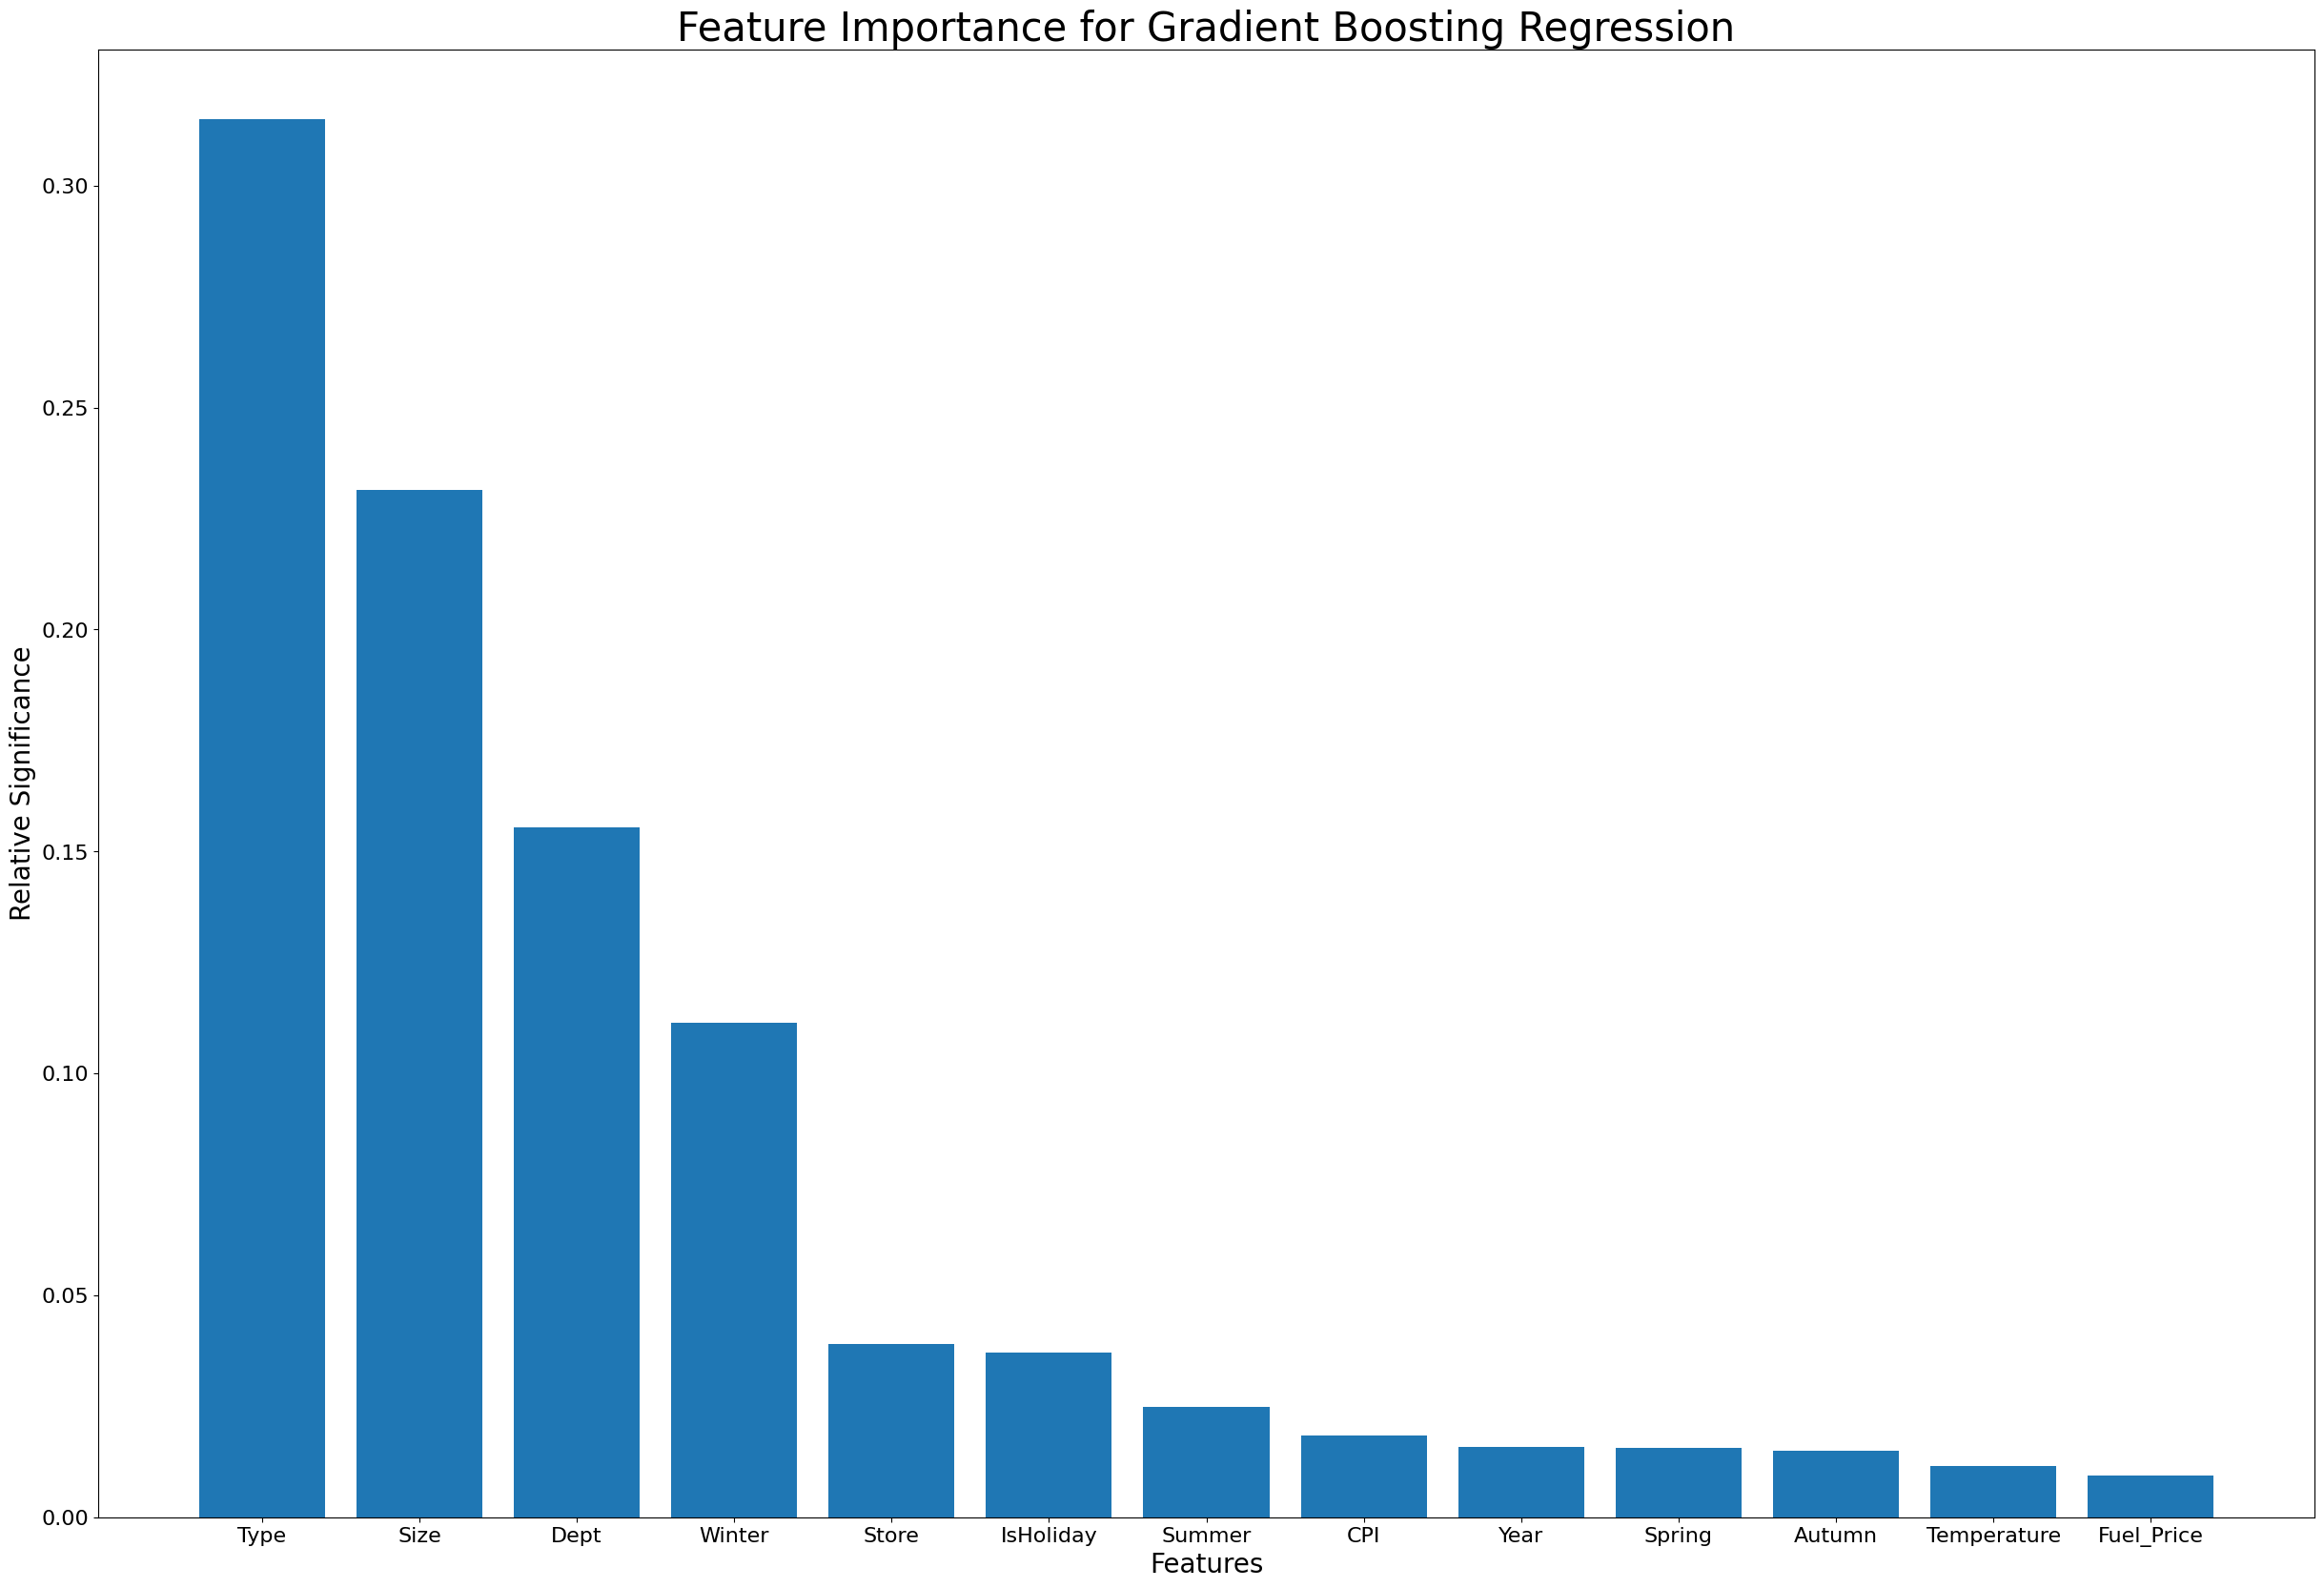

In [ ]:
fi = best_model.feature_importances_
indices = np.argsort(fi)[::-1]
holder = []
for i, feature_index in enumerate(indices):
    holder.append(X_train.columns[feature_index])

plt.figure(figsize = (30, 20))
plt.bar(holder, fi[indices], align="center");
plt.title("Feature Importance for Gradient Boosting Regression", fontsize = 30);
plt.xlabel("Features", fontsize = 20)
plt.ylabel("Relative Significance", fontsize = 20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [ ]:
whole_traing_predictions = whole_training.copy()
whole_traing_predictions['Predictions'] = all_predictions
whole_traing_predictions['Month'] = whole_traing_predictions['Date'].dt.strftime('%B')

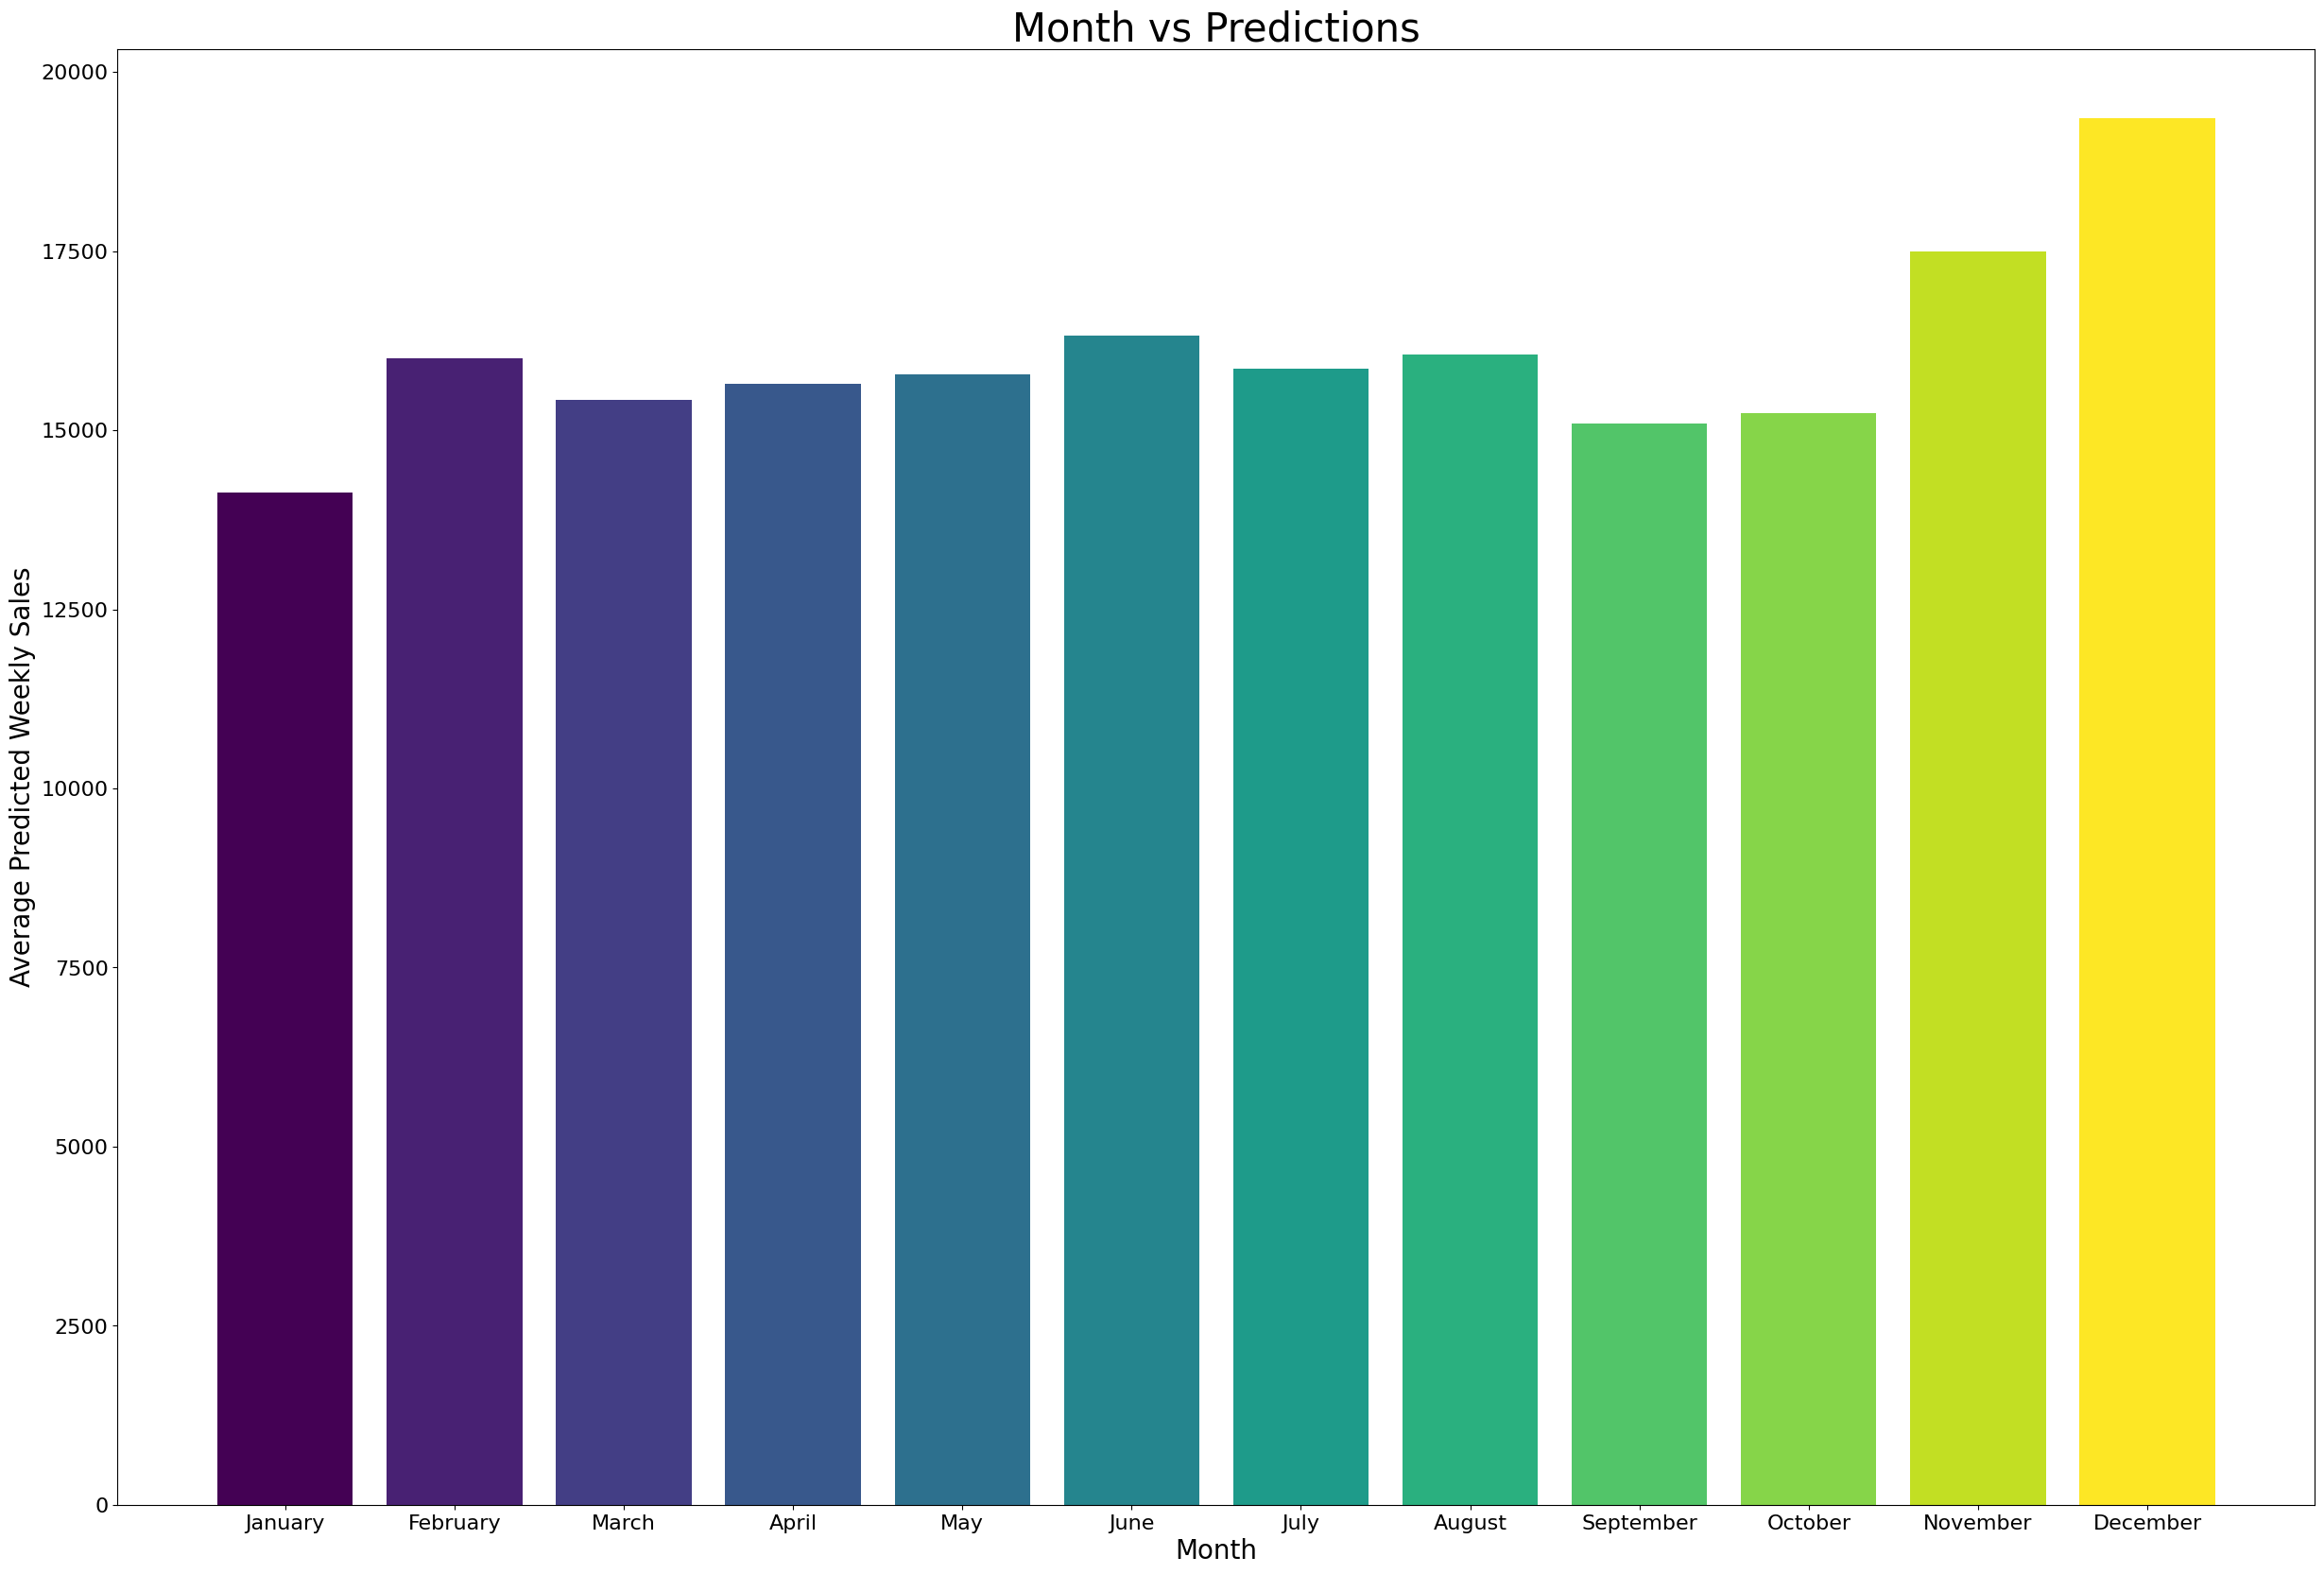

In [ ]:
import calendar

month_plot = whole_traing_predictions[['Month', 'Predictions']].groupby('Month').mean().reset_index()

month_plot['Month'] = pd.Categorical(month_plot['Month'], categories=calendar.month_name[1:], ordered=True)

month_plot = month_plot.sort_values('Month')

plt.figure(figsize=(30, 20))
colors = plt.cm.viridis(np.linspace(0, 1, 12))
plt.bar(month_plot['Month'], month_plot['Predictions'], color=colors)
plt.title('Month vs Predictions', fontsize=30)
plt.ylabel("Average Predicted Weekly Sales", fontsize=20)
plt.xlabel("Month", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

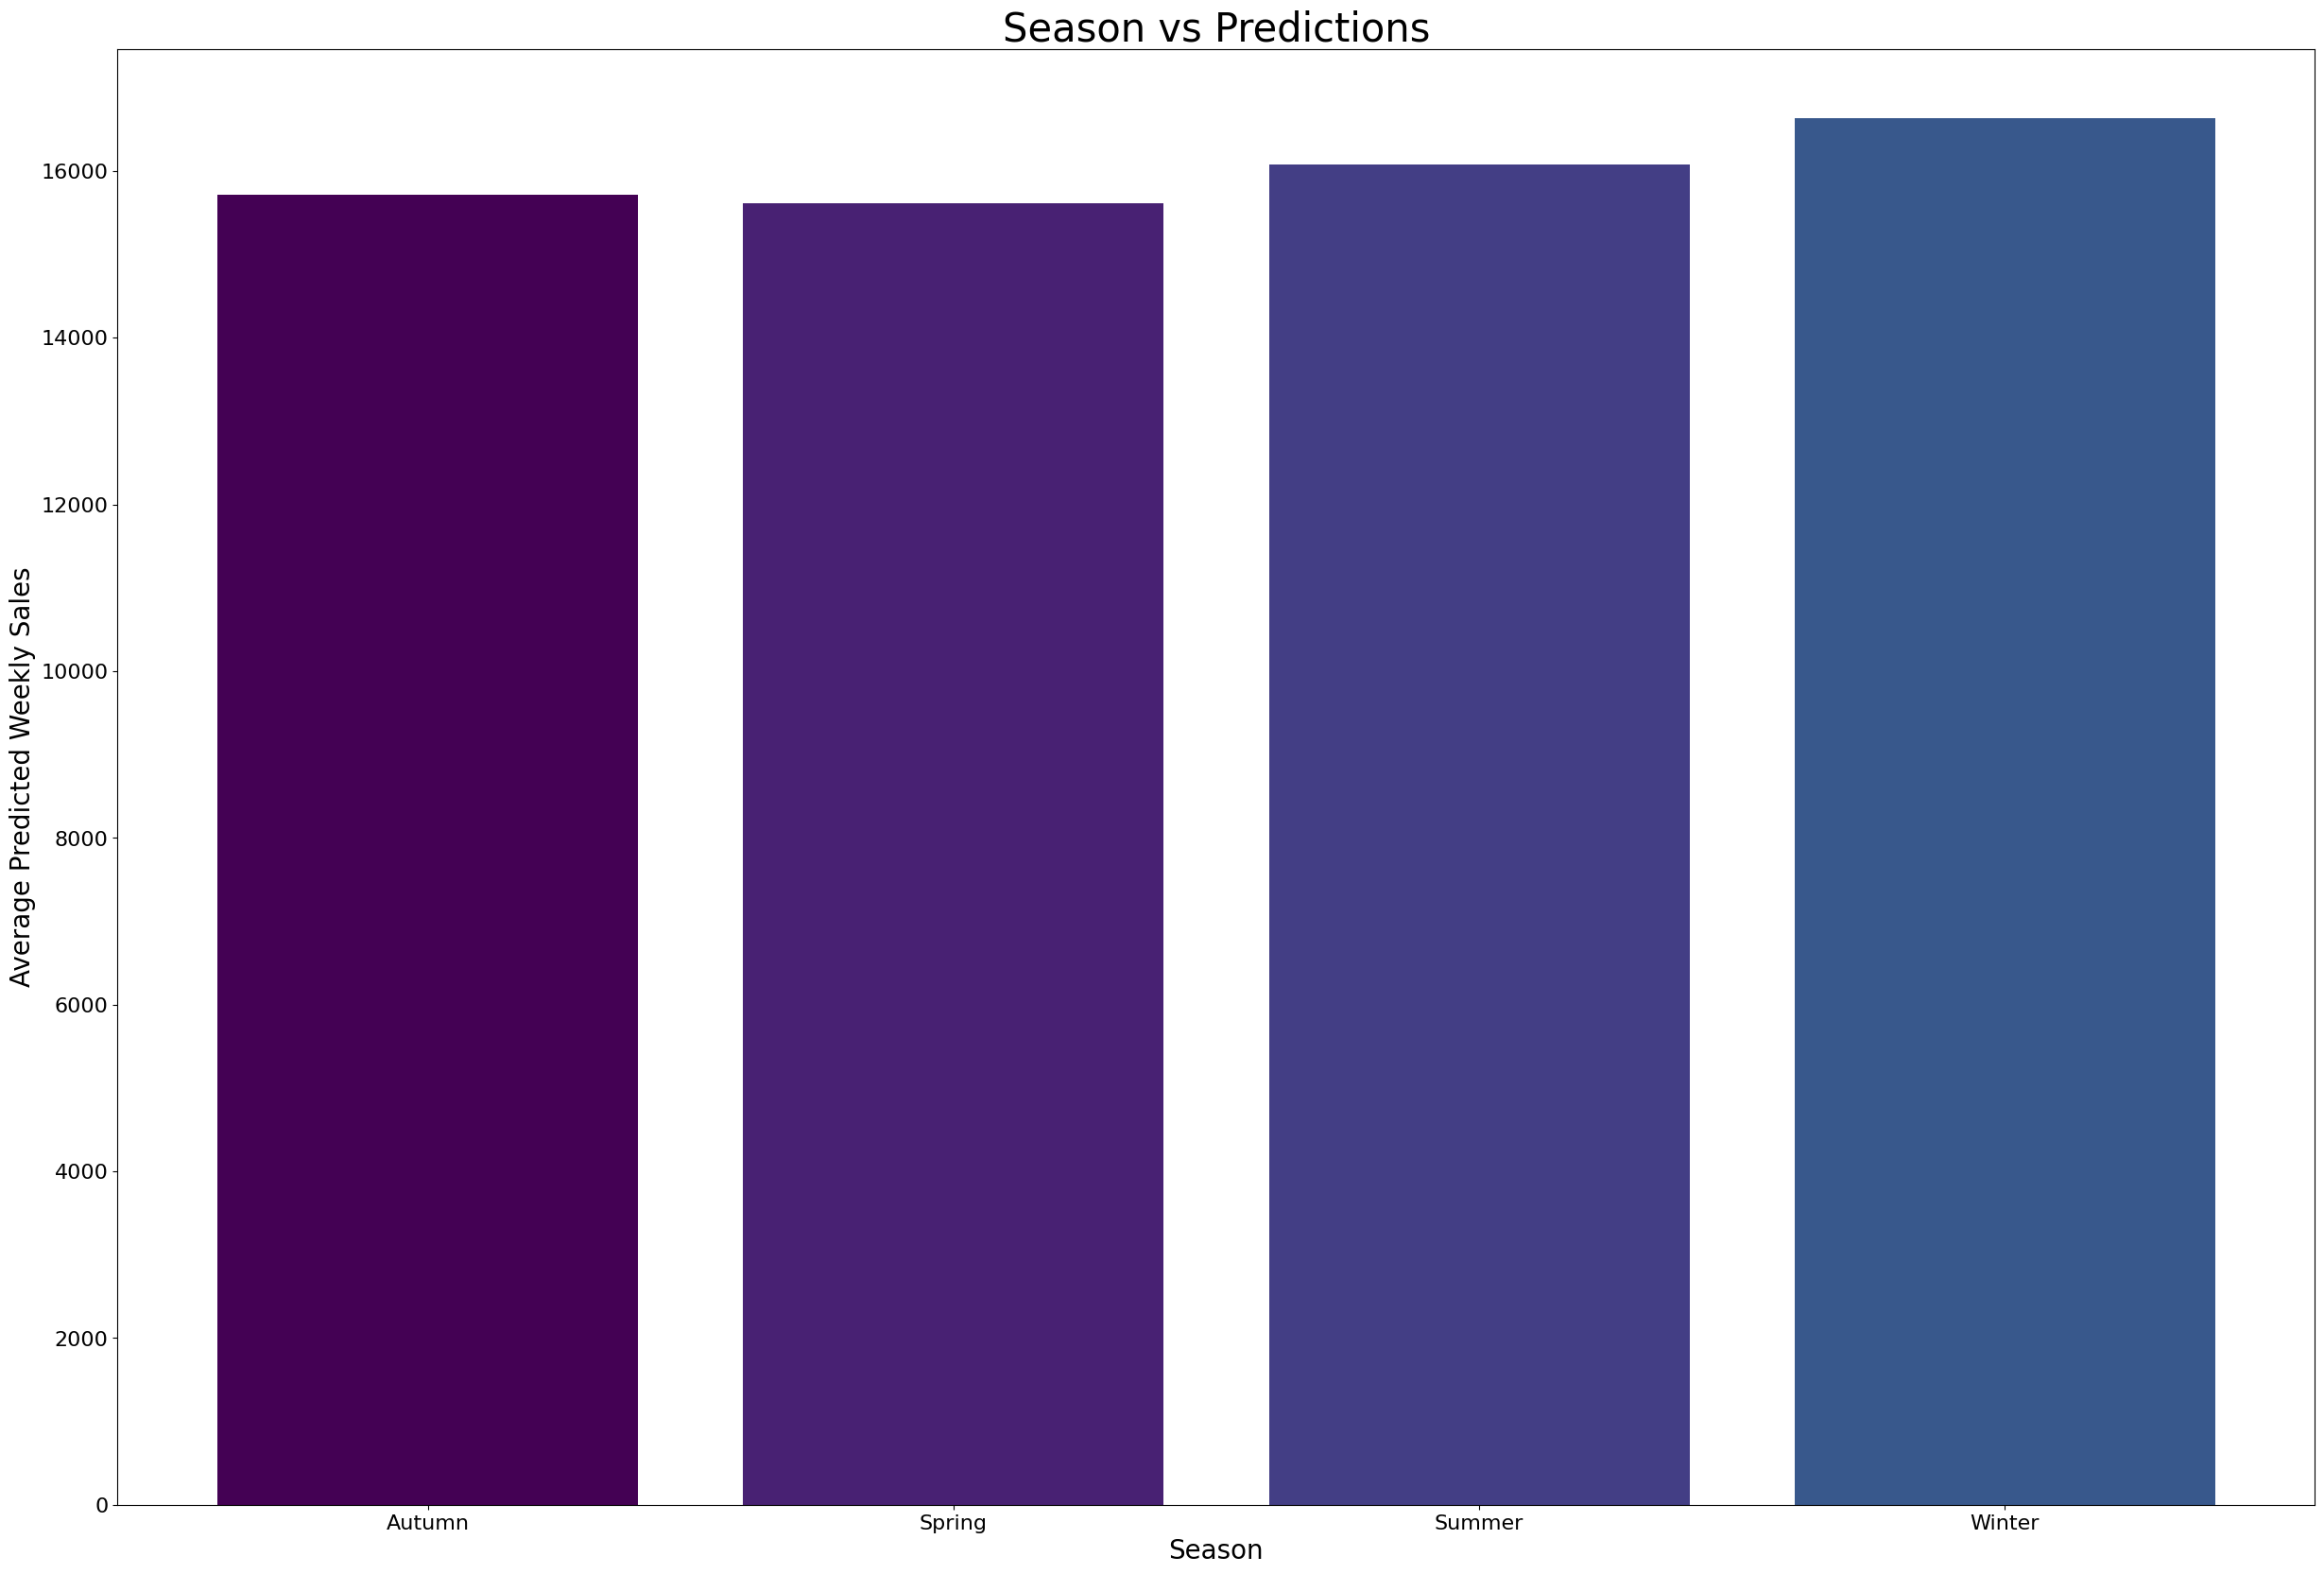

In [ ]:
season_plot = whole_traing_predictions[['Season', 'Predictions']].groupby('Season').mean().reset_index()
plt.figure(figsize = (30, 20))
colors = plt.cm.viridis(np.linspace(0, 1, 12))
plt.bar(season_plot['Season'], season_plot['Predictions'], color = colors)
plt.title('Season vs Predictions', fontsize = 30)
plt.ylabel("Average Predicted Weekly Sales", fontsize=20)
plt.xlabel("Season", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

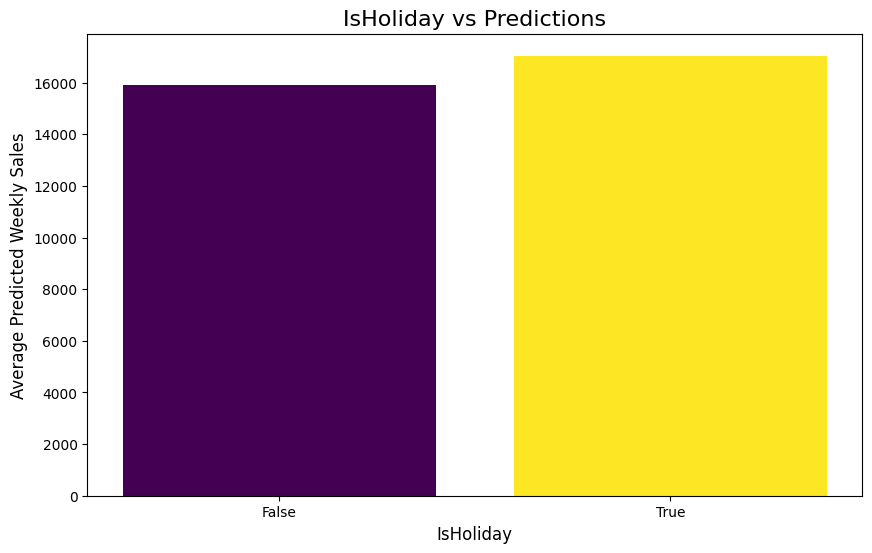

In [ ]:

holiday_plot = whole_traing_predictions[['IsHoliday', 'Predictions']].groupby('IsHoliday').mean().reset_index()

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 2))

plt.bar(holiday_plot['IsHoliday'].astype(str), holiday_plot['Predictions'], color=colors)
plt.title('IsHoliday vs Predictions', fontsize=16)
plt.ylabel("Average Predicted Weekly Sales", fontsize=12)
plt.xlabel("IsHoliday", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
models = ["Random Forest", "XGBoost"]
steps = ["All", "Spring", "Autumn", "Summer", "Winter"]
spring_wmae_values = [rf_spring, gbr_spring]
summer_wmae_values = [rf_summer, gbr_summer]
autumn_wmae_values = [rf_autumn, gbr_autumn]
winter_wmae_values = [rf_winter, gbr_winter]
all_wmae_values = [rf_all, gbr_all]

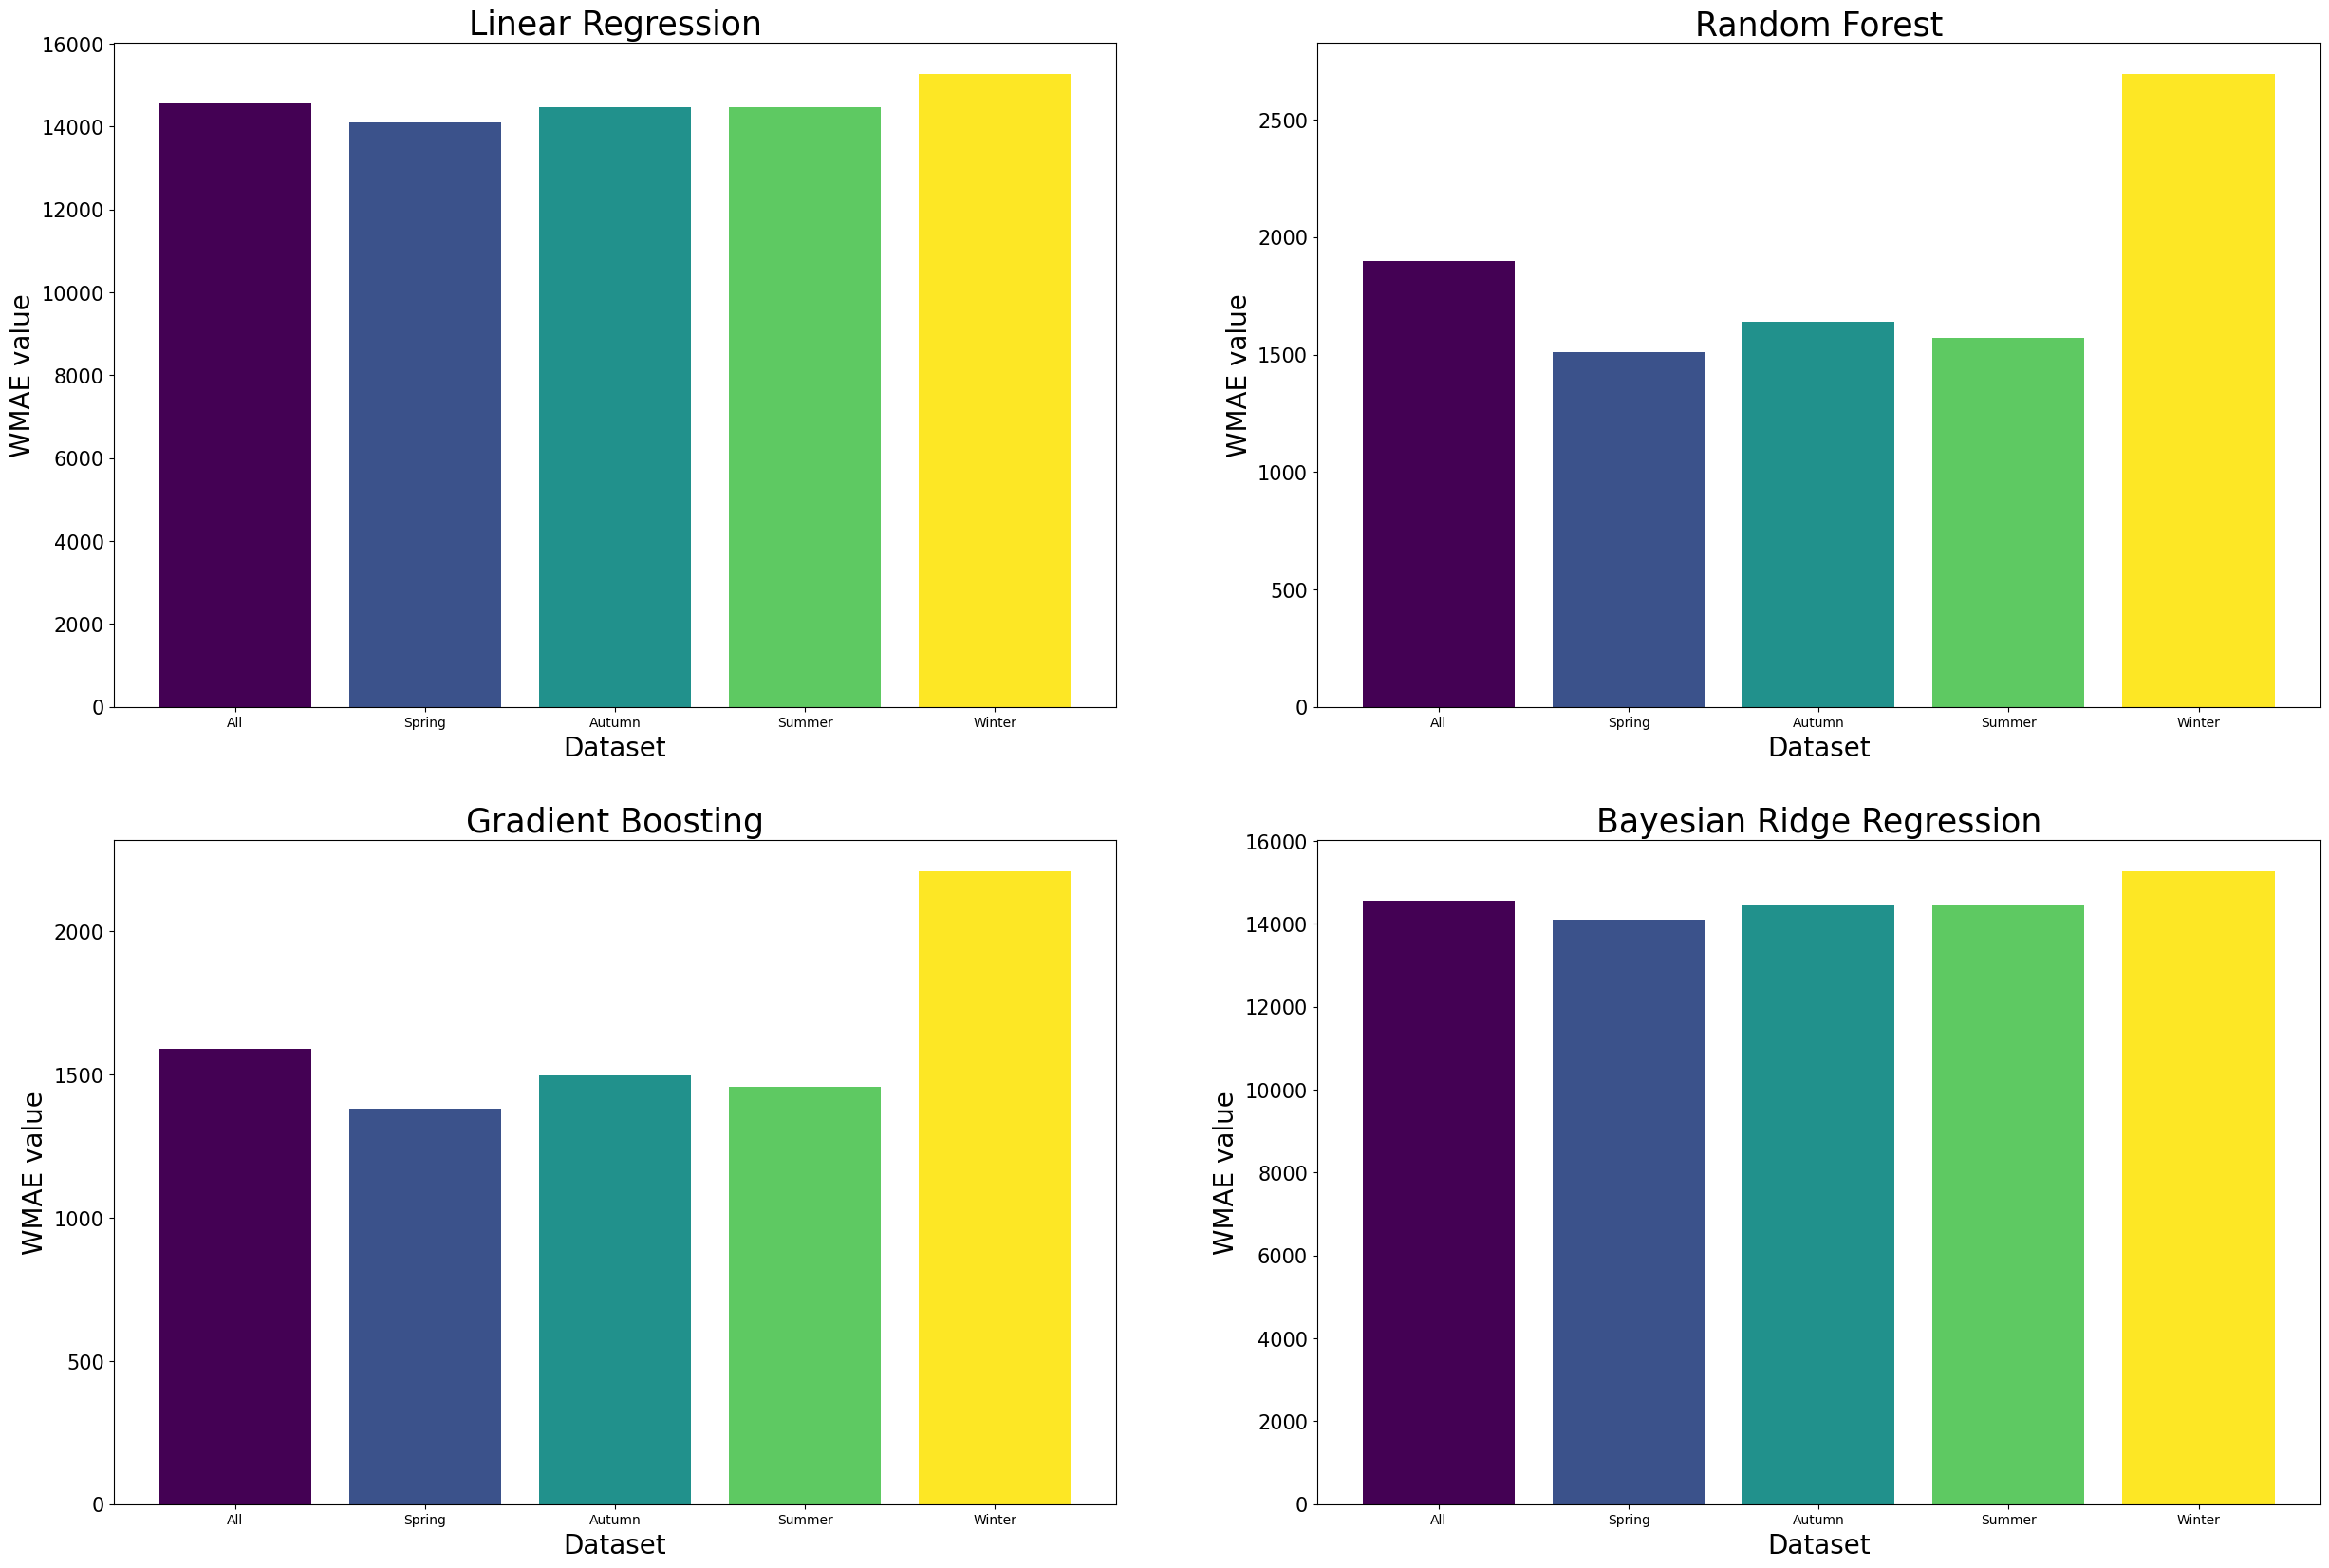

In [ ]:
colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))
axes[0, 0].bar(steps, lin_values, color=colors)
axes[0, 0].set_title('Linear Regression', fontsize=25)
axes[0, 0].set_xlabel('Dataset', fontsize=20)
axes[0, 0].set_ylabel('WMAE value', fontsize=20)
axes[0, 0].tick_params(axis='y', labelsize=15)

axes[0, 1].bar(steps, rf_values, color=colors)
axes[0, 1].set_title('Random Forest', fontsize=25)
axes[0, 1].set_xlabel('Dataset', fontsize=20)
axes[0, 1].set_ylabel('WMAE value', fontsize=20)
axes[0, 1].tick_params(axis='y', labelsize=15)

axes[1, 0].bar(steps, gbr_values, color=colors)
axes[1, 0].set_title('Gradient Boosting', fontsize=25)
axes[1, 0].set_xlabel('Dataset', fontsize=20)
axes[1, 0].set_ylabel('WMAE value', fontsize=20)
axes[1, 0].tick_params(axis='y', labelsize=15)

axes[1, 1].bar(steps, br_values, color=colors)
axes[1, 1].set_title('Bayesian Ridge Regression', fontsize=25)
axes[1, 1].set_xlabel('Dataset', fontsize=20)
axes[1, 1].set_ylabel('WMAE value', fontsize=20)
axes[1, 1].tick_params(axis='y', labelsize=15)

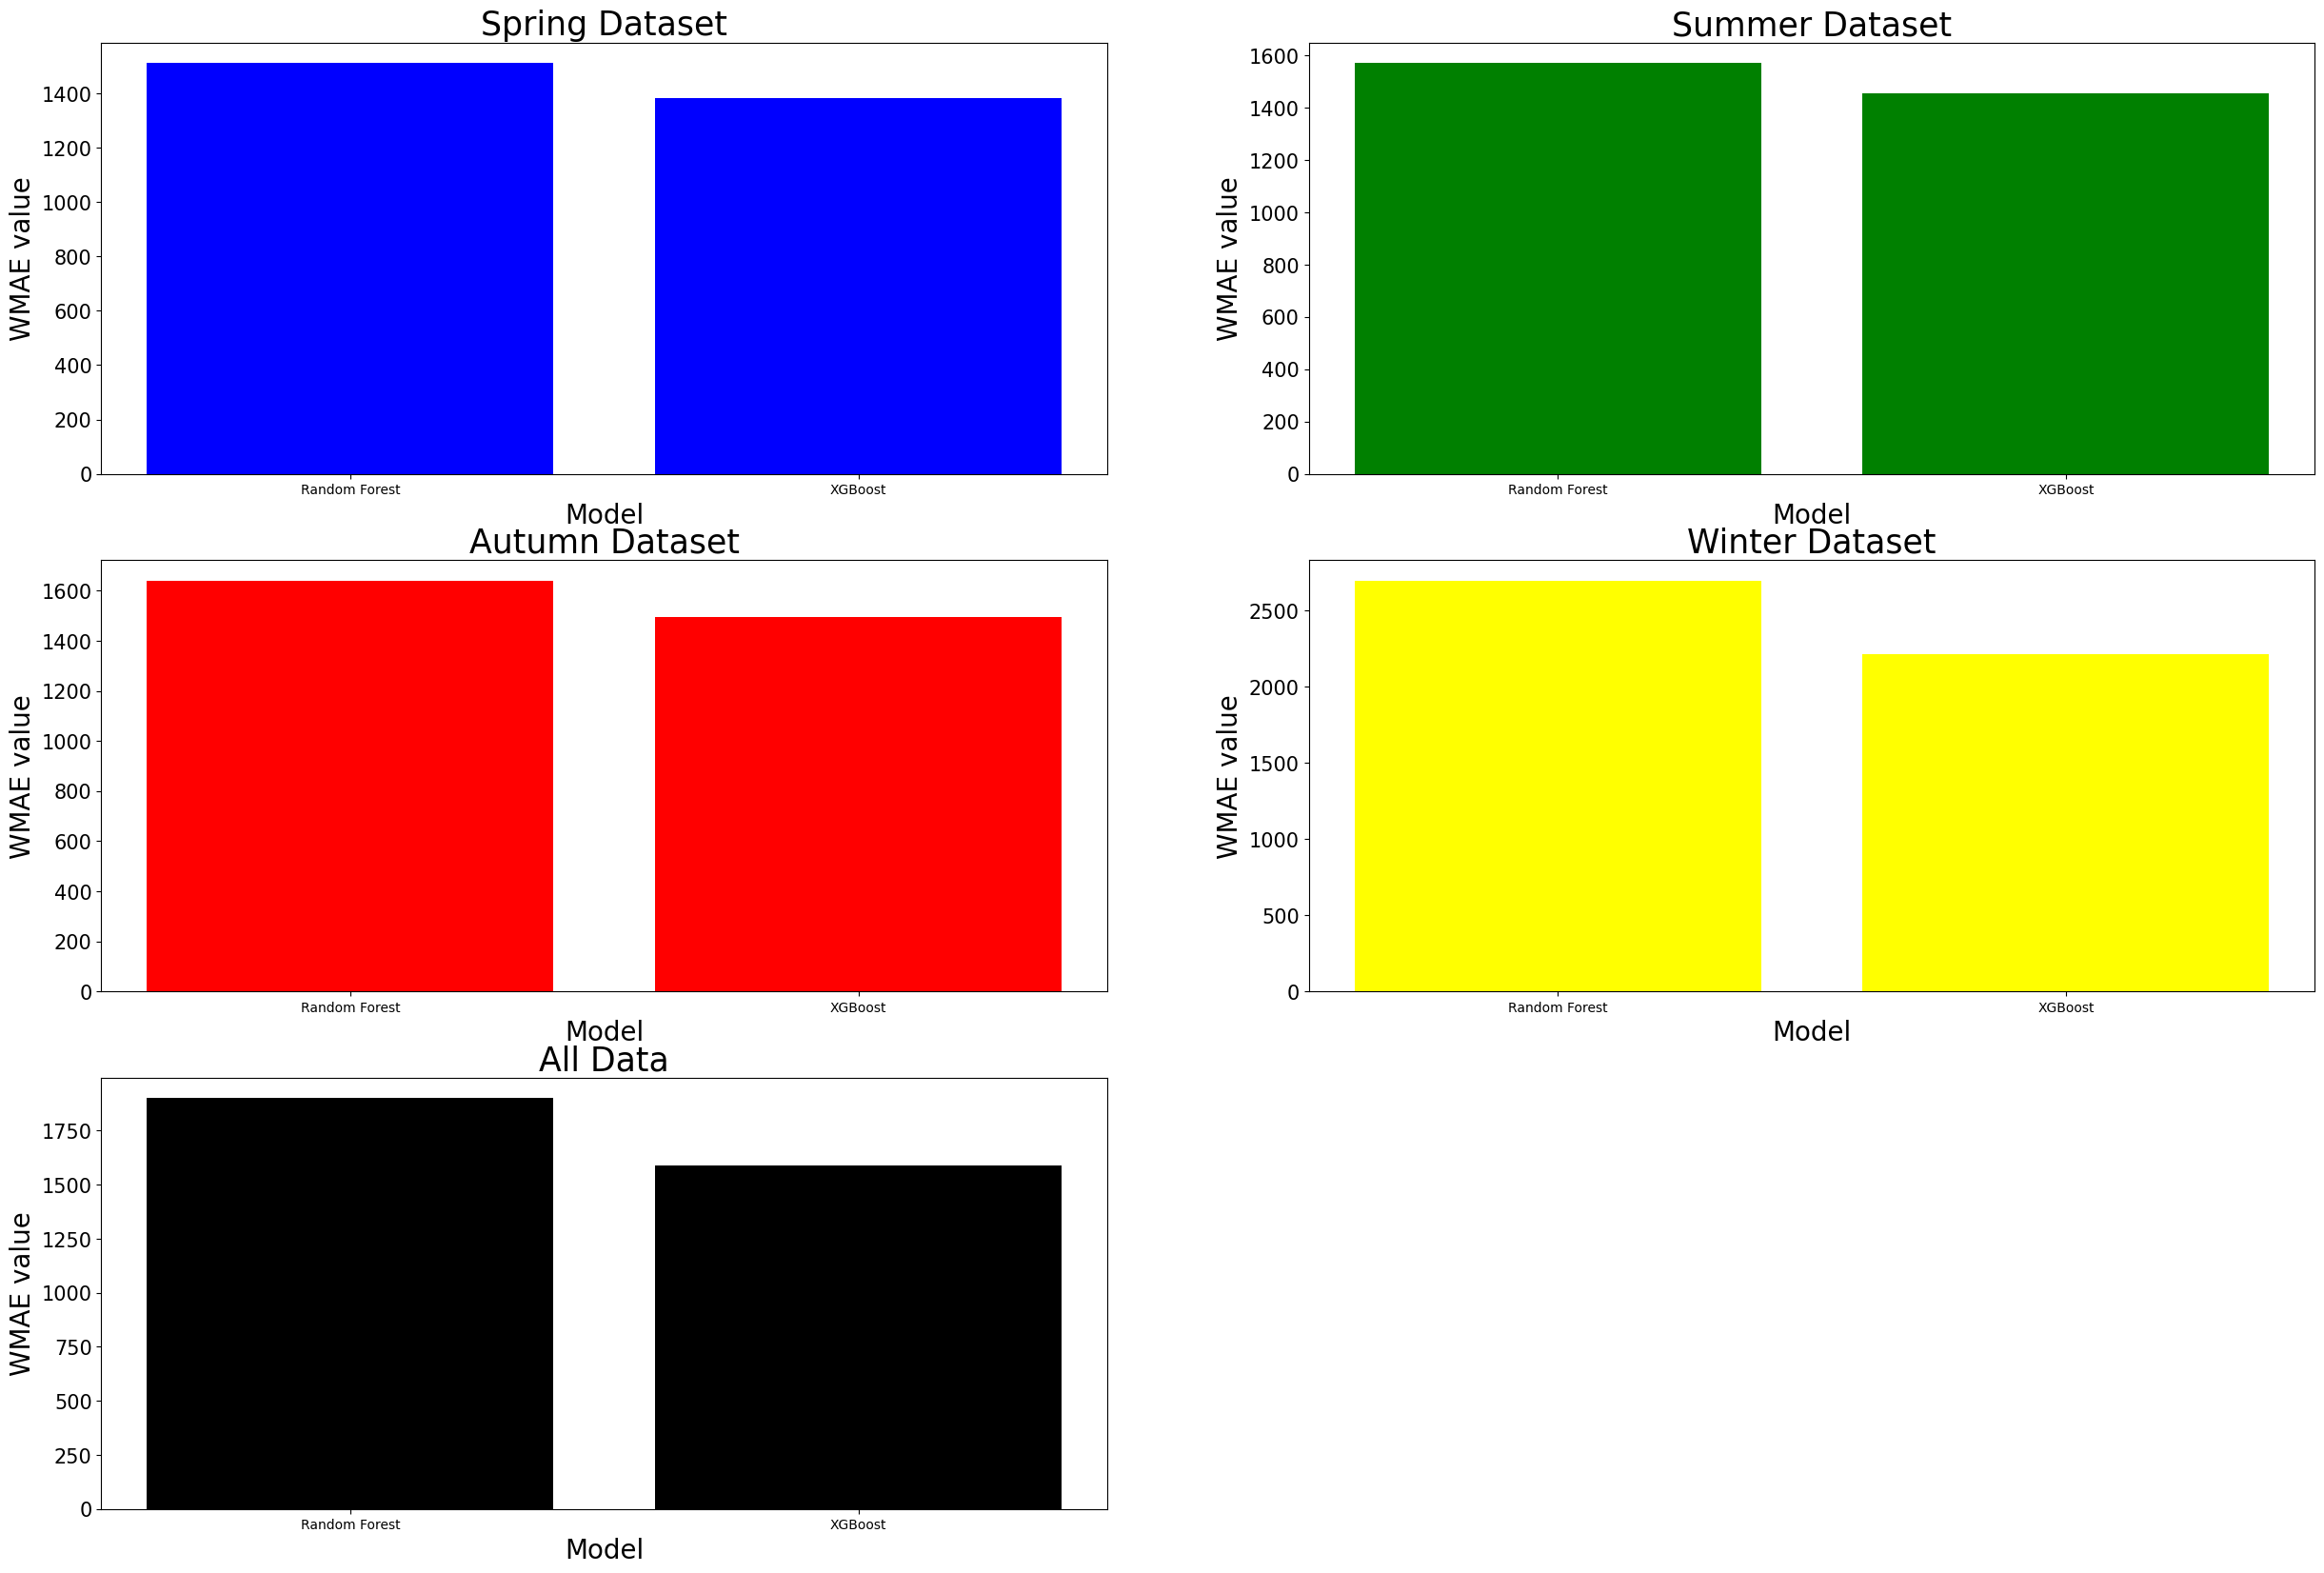

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))
axes[0, 0].bar(models, spring_wmae_values, color="Blue")
axes[0, 0].set_title('Spring Dataset', fontsize=25)
axes[0, 0].set_xlabel('Model', fontsize=20)
axes[0, 0].set_ylabel('WMAE value', fontsize=20)
axes[0, 0].tick_params(axis='y', labelsize=15)

axes[0, 1].bar(models, summer_wmae_values, color="Green")
axes[0, 1].set_title('Summer Dataset', fontsize=25)
axes[0, 1].set_xlabel('Model', fontsize=20)
axes[0, 1].set_ylabel('WMAE value', fontsize=20)
axes[0, 1].tick_params(axis='y', labelsize=15)

axes[1, 0].bar(models, autumn_wmae_values, color="Red")
axes[1, 0].set_title('Autumn Dataset', fontsize=25)
axes[1, 0].set_xlabel('Model', fontsize=20)
axes[1, 0].set_ylabel('WMAE value', fontsize=20)
axes[1, 0].tick_params(axis='y', labelsize=15)

axes[1, 1].bar(models, winter_wmae_values, color="Yellow")
axes[1, 1].set_title('Winter Dataset', fontsize=25)
axes[1, 1].set_xlabel('Model', fontsize=20)
axes[1, 1].set_ylabel('WMAE value', fontsize=20)
axes[1, 1].tick_params(axis='y', labelsize=15)

axes[2, 0].bar(models, all_wmae_values, color="black")
axes[2, 0].set_title('All Data', fontsize=25)
axes[2, 0].set_xlabel('Model', fontsize=20)
axes[2, 0].set_ylabel('WMAE value', fontsize=20)
axes[2, 0].tick_params(axis='y', labelsize=15)

fig.delaxes(axes[2, 1])